Gruhit Patel - 500224478

In [ ]:
!unzip -qq /content/CovidXRayImages.zip

In [ ]:
# remove the lung masks images from each directory
!rm -r "/content/Val/COVID-19/lung masks"
!rm -r "/content/Val/Non-COVID/lung masks"
!rm -r "/content/Val/Normal/lung masks"

In [ ]:
!pip install -q lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
import tensorflow as tf
from tensorflow import keras

# Import necessary layes
from keras.layers import Conv2D, Dropout, MaxPooling2D, Dense, Flatten, BatchNormalization

# Using metrics from sklearn
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc

import numpy as np

from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

import os
from tqdm.notebook import tqdm as pbar

import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries, felzenszwalb

import warnings
warnings.filterwarnings('ignore')

In [ ]:
covid_img_dir = "/content/Val/COVID-19/images"
print("Covid images: ", len(os.listdir(covid_img_dir)))

noncovid_img_dir = "/content/Val/Non-COVID/images"
print("noncovid_img_dir: ", len(os.listdir(noncovid_img_dir)))

normal_img_dir = "/content/Val/Normal/images"
print("normal_img_dir: ", len(os.listdir(normal_img_dir)))

Covid images:  1903
noncovid_img_dir:  1802
normal_img_dir:  1712


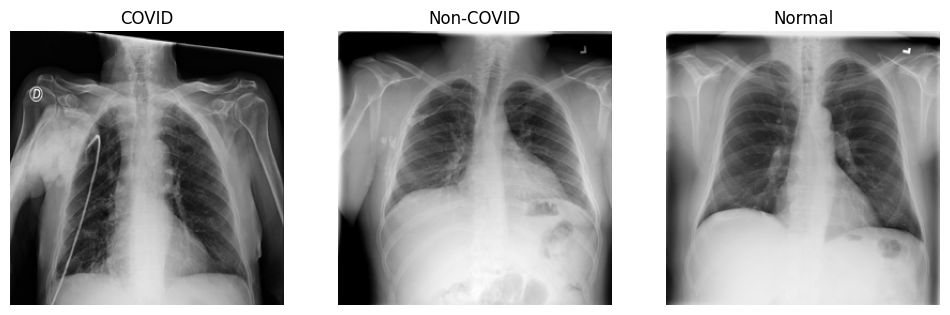

In [ ]:
# Display a sample image and print its size
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
img = Image.open(os.path.join(covid_img_dir, os.listdir(covid_img_dir)[0]))
plt.imshow(img, cmap="gray")
plt.title("COVID")
plt.axis("off")

plt.subplot(1, 3, 2)
img = Image.open(os.path.join(noncovid_img_dir, os.listdir(noncovid_img_dir)[0]))
plt.imshow(img, cmap="gray")
plt.title("Non-COVID")
plt.axis("off")

plt.subplot(1, 3, 3)
img = Image.open(os.path.join(normal_img_dir, os.listdir(normal_img_dir)[0]))
plt.title("Normal")
plt.imshow(img, cmap="gray")
plt.axis("off")

plt.show()

In [ ]:
data_dir = "/content/Val"

TARGET_SIZE = (256, 256)
BATCH_SIZE = 16
CLASSES = ['COVID-19', 'Non-COVID', 'Normal']

image_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255.,
    validation_split = 0.1,
)

train_datagen = image_datagen.flow_from_directory(
    data_dir,
    target_size = TARGET_SIZE,
    color_mode = "grayscale",
    class_mode = "categorical",
    batch_size = BATCH_SIZE,
    classes = CLASSES,
    subset = 'training',
    keep_aspect_ratio = True,
    shuffle = True
)

val_datagen = image_datagen.flow_from_directory(
    data_dir,
    target_size = TARGET_SIZE,
    color_mode = "grayscale",
    class_mode = "categorical",
    batch_size = BATCH_SIZE,
    classes = CLASSES,
    subset = "validation",
    keep_aspect_ratio = True,
    shuffle = True
)

Found 4876 images belonging to 3 classes.
Found 541 images belonging to 3 classes.


In [ ]:
label_cat = train_datagen.class_indices
cat_label = {v:k for k, v in label_cat.items()}

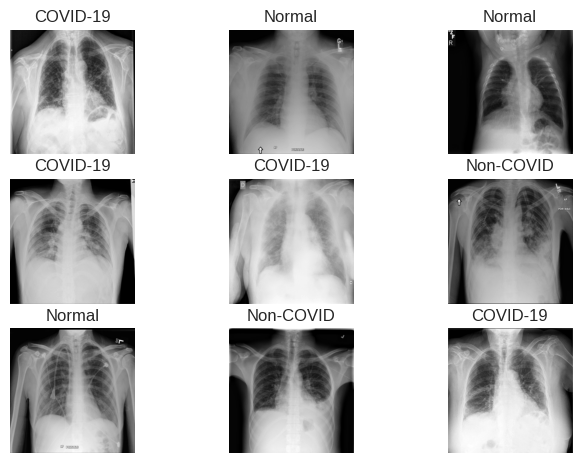

In [ ]:
for img, label in train_datagen:
    label = tf.argmax(label, axis=-1)

    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(img[i], cmap='gray')
        plt.title(f'{cat_label[label[i].numpy()]}')
        plt.axis('off')

    break

## Create a baseline model
This model will be used for evaluating against finetune model in order to assess that if the model has made improvement or not.

In [ ]:
# We will have a simple model architecture with just 3 convolution layers each with ReLU activation
# Followed by MaxPooling and final classifier head
def create_baseline_model(input_shape, n_classes: int):
    model = tf.keras.models.Sequential()

    model.add(Conv2D(32, kernel_size=(3,3), input_shape=(*input_shape, 1), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, kernel_size=(3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))

    model.add(Dense(n_classes, activation='softmax'))

    return model

In [ ]:
# we will not have any drop out for the baseline model
modelv1 = create_baseline_model(TARGET_SIZE, len(CLASSES))

modelv1.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics = [
        tf.keras.metrics.CategoricalAccuracy(name='cat_acc'),
    ]
)

modelv1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 64, 64, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 32, 32, 128)       0

In [ ]:
train_steps = train_datagen.n // train_datagen.batch_size
val_steps = val_datagen.n // val_datagen.batch_size
EPOCHS = 15

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_cat_acc',
    patience = 5
)

# Checkpoint to save best model
best_model_cb = tf.keras.callbacks.ModelCheckpoint(
    'base_model.keras',
    monitor = 'val_cat_acc'
)

hist1 = modelv1.fit(
    train_datagen,
    steps_per_epoch = train_steps,
    validation_data = val_datagen,
    validation_steps = val_steps,
    shuffle = True,
    epochs = EPOCHS,
    callbacks = [early_stopping, best_model_cb]
)

Epoch 1/15
304/304 [==============================] - 25s 62ms/step - loss: 0.8422 - cat_acc: 0.6543 - val_loss: 0.5544 - val_cat_acc: 0.8201
Epoch 2/15
304/304 [==============================] - 19s 61ms/step - loss: 0.4889 - cat_acc: 0.8041 - val_loss: 0.5395 - val_cat_acc: 0.8182
Epoch 3/15
304/304 [==============================] - 14s 44ms/step - loss: 0.3361 - cat_acc: 0.8714 - val_loss: 0.4490 - val_cat_acc: 0.8428
Epoch 4/15
304/304 [==============================] - 14s 46ms/step - loss: 0.2600 - cat_acc: 0.8951 - val_loss: 0.4225 - val_cat_acc: 0.8731
Epoch 5/15
304/304 [==============================] - 14s 46ms/step - loss: 0.1796 - cat_acc: 0.9288 - val_loss: 0.5150 - val_cat_acc: 0.8561
Epoch 6/15
304/304 [==============================] - 14s 46ms/step - loss: 0.1173 - cat_acc: 0.9578 - val_loss: 0.6329 - val_cat_acc: 0.8617
Epoch 7/15
304/304 [==============================] - 13s 44ms/step - loss: 0.0671 - cat_acc: 0.9763 - val_loss: 0.6513 - val_cat_acc: 0.8731
Epoch 

Wow ! This model at the end of training ends up in completly overfitting. Our task is to get that 1.0000 in the val_cat_acc which will not be tough hypothetically.

In [ ]:
def visualize_model(history):
    plt.figure(figsize=(14, 6))
    # Extract the metrics to visulalize
    metrics = []

    # Getting all the metrics we have while model training
    hist_metrics = history.history.keys()
    for item in hist_metrics:
        if item.startswith("val"):
            continue

        metrics.append(item)


    for indx, metric in enumerate(metrics):
        title = f'{metric}'
        legends = [metric]
        plt.subplot(1, 2, indx+1)
        plt.plot(history.history[metric], label=metric, marker='o')

        val_metric = 'val_' + metric
        if val_metric in hist_metrics:
            title += f" vs {val_metric}"
            plt.plot(history.history[val_metric], label=val_metric, marker='^')
            legends.append(val_metric)

        plt.legend(legends)
        plt.title(title)

    plt.show()

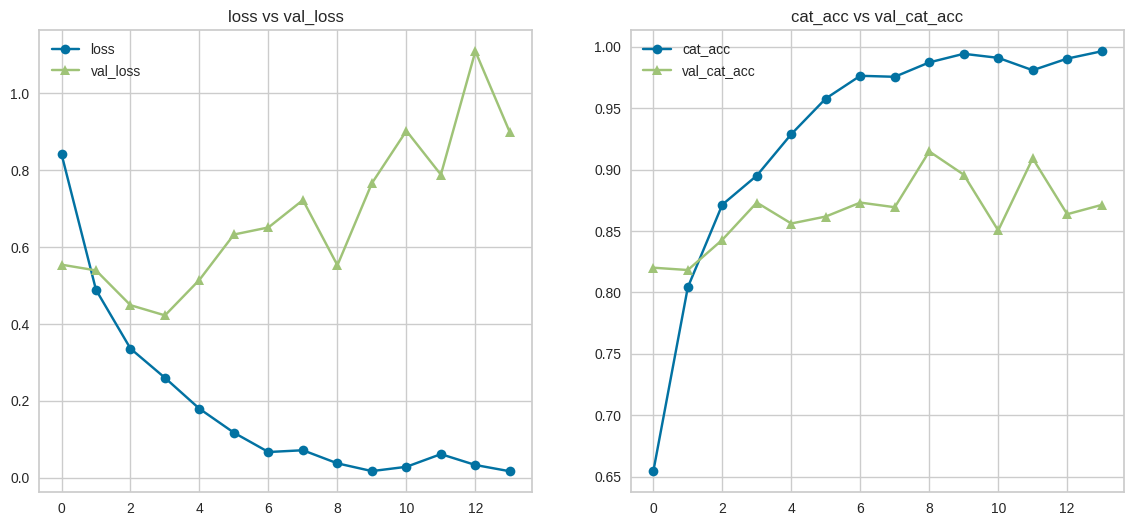

In [ ]:
visualize_model(hist1)

### Cross Validating Model

In [ ]:
def get_preds(model, val_datagen):

    # Get the prediction for the test_dataset
    true_labels_probs = []
    pred_labels_probs = []

    val_steps = val_datagen.n // val_datagen.batch_size
    for indx, (img, label) in pbar(enumerate(val_datagen), total=val_steps):
        true_labels_probs.append(label)

        preds = model.predict(img, verbose=0)
        pred_labels_probs.append(preds)

        if indx+1 > val_steps:
            break

    true_labels_probs = tf.concat(true_labels_probs, axis=0)
    pred_labels_probs = tf.concat(pred_labels_probs, axis=0)

    true_label_cat = tf.argmax(true_labels_probs, axis=-1).numpy()
    pred_label_cat = tf.argmax(pred_labels_probs, axis=-1).numpy()

    return true_labels_probs, true_label_cat, pred_labels_probs, pred_label_cat

In [ ]:
base_model_path = '/content/base_model.keras'
true_labels_probs, true_label_cat, pred_labels_probs, pred_label_cat = get_preds(base_model_path, val_datagen)

  0%|          | 0/33 [00:00<?, ?it/s]

In [ ]:
conf_mat1 = confusion_matrix(true_label_cat, pred_label_cat)
clf_report1 = classification_report(true_label_cat, pred_label_cat, target_names=label_cat.keys())

print(clf_report1)

              precision    recall  f1-score   support

    COVID-19       0.94      0.89      0.92       190
   Non-COVID       0.89      0.85      0.87       180
      Normal       0.78      0.87      0.82       171

    accuracy                           0.87       541
   macro avg       0.87      0.87      0.87       541
weighted avg       0.88      0.87      0.87       541



In [ ]:
def plot_confusion_matrix(conf_matrix, labels):
    sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("Ground Truth")
    plt.show()

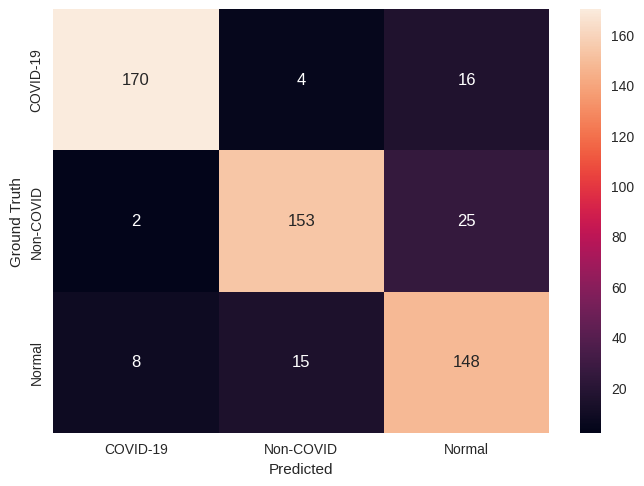

In [ ]:
plot_confusion_matrix(conf_mat1, labels=label_cat.keys())

This can be a fairly acceptable model in itself. But the issue is in what it is mispredicting. For example if model is provided a normal person's image and if it predicts it as COVID or Non-COVID that its alright. But here the scenario is reverse of it. Here the a COVID patient's X-Ray image is provided and the model is predicting it to be Normal which is not good in practically. Hence we need to improvise the overfitting and make the model more accurate to overcome this issue.

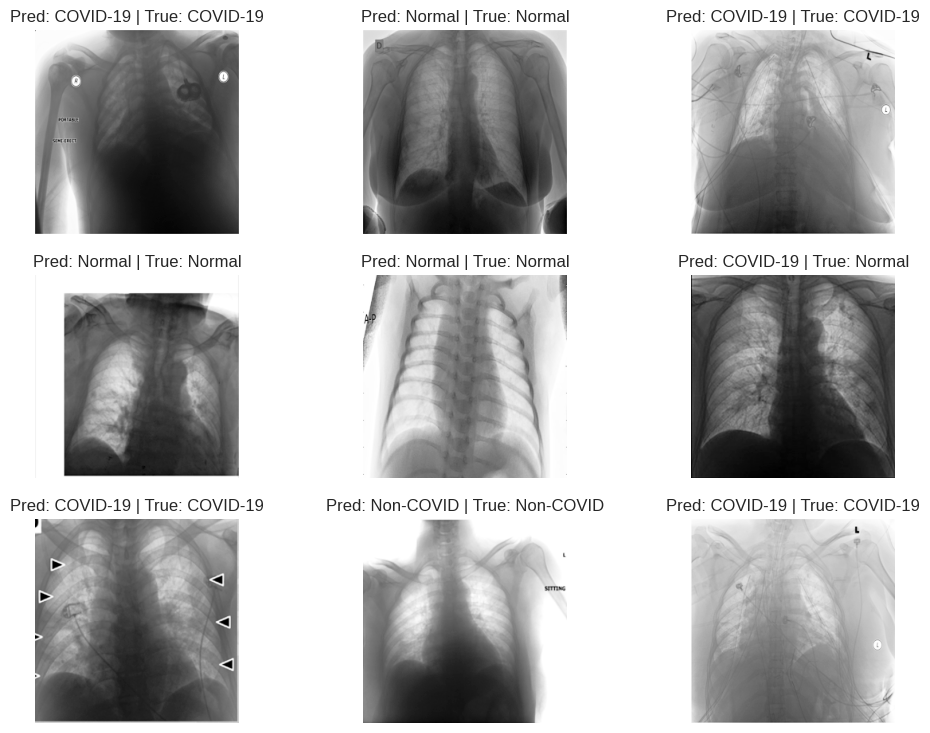

In [ ]:
plt.figure(figsize=(12, 9))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(img[-i])
    plt.title(f'Pred: {cat_label[pred_label_cat[-i]]} | True: {cat_label[true_label_cat[-i]]}')
    plt.axis("off")

plt.show()

Over here the model is overfitting so for that we need to decrease the model dimension. However, we can still add the augmentation to increase the training data. So we will start with that.

In [ ]:
def plot_roc_curve(cat_label, y_true, y_pred):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i, label in cat_label.items():
        # Calculate the False Positive and True Positive rate for each class individually
        fpr[label], tpr[label], _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc[label] = auc(fpr[label], tpr[label])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.numpy().ravel(), y_pred.numpy().ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Plotting the metrics
    plt.plot(fpr["micro"], tpr["micro"], label=f"Micro-avg ROC curve (area = {roc_auc['micro']:.2f})")

    # Plot all class FPR and TPR rates
    for label in cat_label.values():
        plt.plot(fpr[label], tpr[label], lw=2, label=f'ROC Curve of {label} (area = {roc_auc[label]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve for each class")
    plt.legend(loc='lower right')
    plt.show()

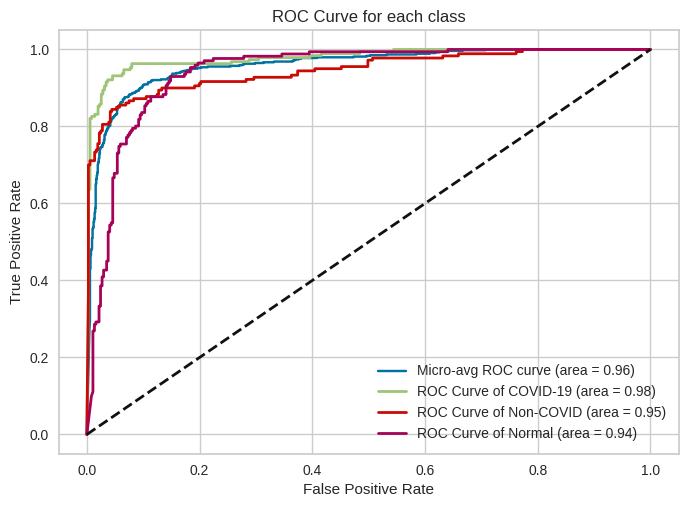

In [ ]:
plot_roc_curve(cat_label, true_labels_probs, pred_labels_probs)

## Finetune v1
For finetuning we will do the following things
*   Add Regularizer in the Model to punish it weight for making major modification in the weights.
*   Add dropout to randomly mask some of the neurons when making predictions
*   Lastly, we in order to add more data to we will also add some augmentation in the dataset.

Hope Factor

*   We will add Initializer to the parameters expecting that it might lead to better results



In [ ]:
data_dir = "/content/Val"

TARGET_SIZE = (256, 256)
BATCH_SIZE = 32
CLASSES = ['COVID-19', 'Non-COVID', 'Normal']

image_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255.,
    validation_split = 0.1,
    zoom_range = 0.2,
    horizontal_flip = True,
    shear_range = 0.2,
    brightness_range = [0.4, 1.5],
)

train_datagen = image_datagen.flow_from_directory(
    data_dir,
    target_size = TARGET_SIZE,
    color_mode = "grayscale",
    class_mode = "categorical",
    batch_size = BATCH_SIZE,
    classes = CLASSES,
    subset = 'training',
    keep_aspect_ratio = True,
    shuffle = True
)

val_datagen = image_datagen.flow_from_directory(
    data_dir,
    target_size = TARGET_SIZE,
    color_mode = "grayscale",
    class_mode = "categorical",
    batch_size = BATCH_SIZE,
    classes = CLASSES,
    subset = "validation",
    keep_aspect_ratio = True,
    shuffle = True
)

Found 4876 images belonging to 3 classes.
Found 541 images belonging to 3 classes.


In [ ]:
def create_finetune_model(input_shape, regs, n_classes, drop_rate = 0.1):
    model = tf.keras.models.Sequential()

    model.add(Conv2D(32, kernel_size=(3,3), input_shape=(*input_shape, 1), kernel_regularizer=regs, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(drop_rate))

    model.add(Conv2D(64, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=regs))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(drop_rate))

    model.add(Conv2D(128, kernel_size=(3,3), padding='same', activation='relu',  kernel_regularizer=regs))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(drop_rate))

    model.add(Conv2D(256, kernel_size=(3,3), padding='same', activation='relu',  kernel_regularizer=regs))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(drop_rate))

    model.add(Flatten())

    model.add(Dense(512, activation='relu',  kernel_regularizer=regs))
    model.add(Dropout(drop_rate))

    model.add(Dense(n_classes, activation='softmax',  kernel_regularizer=regs))

    return model

In [ ]:
# By Emppirical Rule-of-Thumb we will set the Penalty coef to be 0.0001
regularizer = tf.keras.regularizers.L1(0.00005)

# modelv2 = create_finetune_model(TARGET_SIZE, len(CLASSES), initializer, regularizer, drop_rate=0.25)
modelv2 = create_finetune_model(TARGET_SIZE, regularizer, len(CLASSES))

modelv2.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics = [
        tf.keras.metrics.CategoricalAccuracy(name='cat_acc'),
    ]
)

modelv2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 32)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 128, 128, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 64, 64, 64)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 64, 64, 64)        0

In [ ]:
EPOCHS = 50

finetunev1_model_cb = tf.keras.callbacks.ModelCheckpoint(
    'finetune_model_v1.keras',
    monitor='val_cat_acc'
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_cat_acc',
    patience = 5
)

hist2 = modelv2.fit(
    train_datagen,
    validation_data = val_datagen,
    callbacks = [finetunev1_model_cb],
    epochs = EPOCHS
)

Epoch 1/50
153/153 [==============================] - 53s 316ms/step - loss: 2.5785 - cat_acc: 0.4428 - val_loss: 1.4395 - val_cat_acc: 0.5952
Epoch 2/50
153/153 [==============================] - 50s 324ms/step - loss: 1.3871 - cat_acc: 0.5425 - val_loss: 1.2943 - val_cat_acc: 0.5970
Epoch 3/50
153/153 [==============================] - 51s 335ms/step - loss: 1.2927 - cat_acc: 0.5582 - val_loss: 1.2563 - val_cat_acc: 0.6470
Epoch 4/50
153/153 [==============================] - 51s 333ms/step - loss: 1.2905 - cat_acc: 0.5568 - val_loss: 1.2324 - val_cat_acc: 0.6285
Epoch 5/50
153/153 [==============================] - 54s 351ms/step - loss: 1.2377 - cat_acc: 0.5654 - val_loss: 1.1738 - val_cat_acc: 0.6580
Epoch 6/50
153/153 [==============================] - 53s 344ms/step - loss: 1.2484 - cat_acc: 0.5488 - val_loss: 1.1622 - val_cat_acc: 0.6433
Epoch 7/50
153/153 [==============================] - 52s 340ms/step - loss: 1.2063 - cat_acc: 0.5761 - val_loss: 1.0978 - val_cat_acc: 0.6747

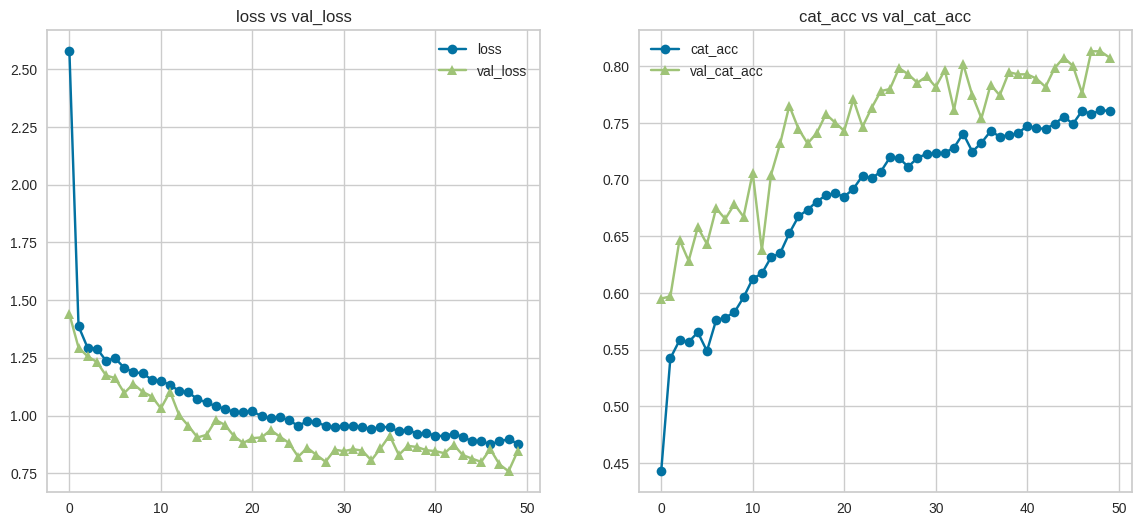

In [ ]:
visualize_model(hist2)

## Model validation

In [ ]:
ftv1_model_path = '/content/finetune_model_v1.keras'
modelv2.load_weights(ftv1_model_path)
true_labels_probs, true_label_cat, pred_labels_probs, pred_label_cat = get_preds(modelv2, val_datagen)

  0%|          | 0/33 [00:00<?, ?it/s]

In [ ]:
conf_mat2 = confusion_matrix(true_label_cat, pred_label_cat)
clf_report2 = classification_report(true_label_cat, pred_label_cat, target_names=label_cat.keys())

print(clf_report2)

              precision    recall  f1-score   support

    COVID-19       0.77      0.82      0.79       190
   Non-COVID       0.93      0.75      0.83       180
      Normal       0.68      0.77      0.72       171

    accuracy                           0.78       541
   macro avg       0.79      0.78      0.78       541
weighted avg       0.79      0.78      0.78       541



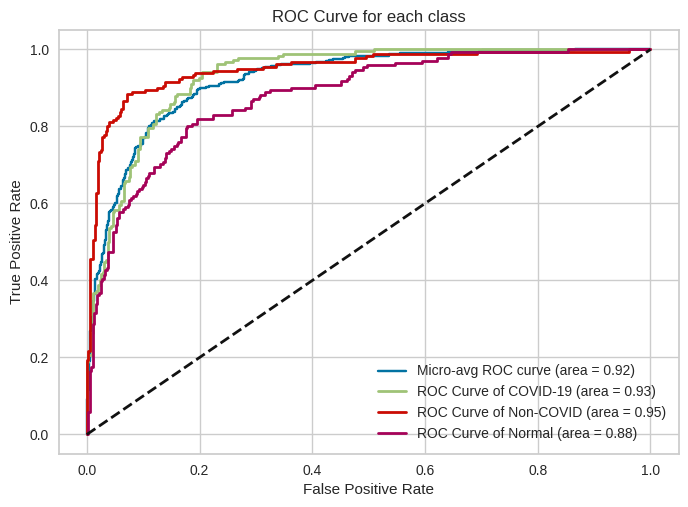

In [ ]:
plot_roc_curve(cat_label, true_labels_probs, pred_labels_probs)

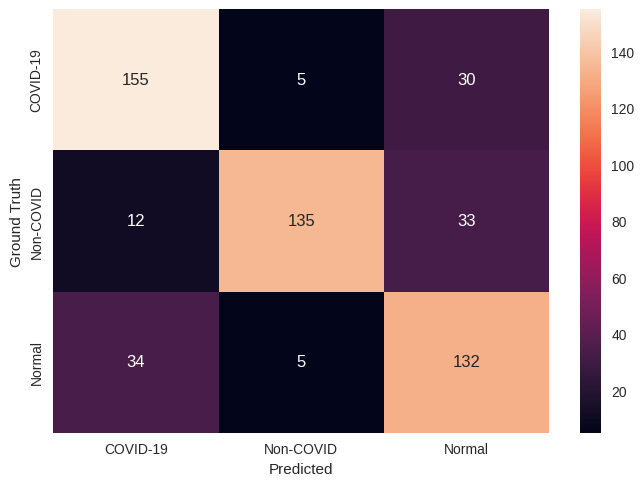

In [ ]:
plot_confusion_matrix(conf_mat2, labels=label_cat.keys())

Although we were not able to overcome the error of mis-predicting the COVID-19 and Non-COVID patient we did compensated with the overfitting. However, a major reason for it can be availability of minimal data.

Moreover, as future work we can try using pretrained models like VCC or AlexNet that has proved to perform expectionally well on image classification task and later can use those model as backbone over a custom classifier head to meet our task.

In [ ]:
def get_mask(image, model, explainer):
    def predict_proba(img):
        return model.predict(img, verbose=0)

    # Create explanation for the image
    img_explanation = explainer.explain_instance(
        image,
        predict_proba,
        top_labels = 3,
        hide_color = 0,
        num_samples = 2000,
        segmentation_fn = lambda x: felzenszwalb(x, scale=100, sigma=0.5, min_size=50)
    )

    masks = {}

    for label in img_explanation.top_labels:
        # Get the maskings for the class - 0 i.e. COVID-19
        _, mask = img_explanation.get_image_and_mask(
            img_explanation.top_labels[label],
            positive_only = True,
            num_features = 10,
            hide_rest = False
        )

        masks[label] = mask


    # Stack the grayscale image 3 times to make it 3-channel
    img_3ch = np.repeat(image, repeats=3, axis=-1)

    return img_3ch, masks

In [ ]:
def interpret_model(studying_case, image, true_label, model, explainer, classes):

    fig, ax = plt.subplots(1, 4, figsize=(20, 4))
    fig.suptitle(studying_case)

    image_3ch, masks = get_mask(image, model, explainer)


    ax[0].set_title(f"True Label: {classes[true_label]}")
    ax[0].imshow(image_3ch)
    ax[0].axis('off')

    for indx, (label, mask) in enumerate(masks.items()):
        ax[indx+1].set_title(f'Pred: {classes[label]}')
        ax[indx+1].imshow(mark_boundaries(image_3ch, mask))

    plt.show()

1/1 [==============================] - 0s 19ms/step


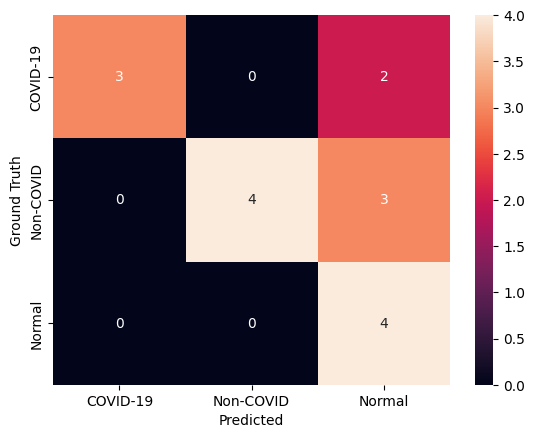

In [ ]:
for inp_images, true_probs in val_datagen:
    pred_probs = modelv2.predict(inp_images)
    break

true_labels = np.argmax(true_probs, axis=-1)
pred_labels = np.argmax(pred_probs, axis=-1)

conf_mat_ = confusion_matrix(true_labels, pred_labels)
plot_confusion_matrix(conf_mat_, label_cat.keys())

***NOTE*** : This particular confusion matrix is a **Hand Picked** scenario that is particular chose to explain the model's understanding of data. You may have to run the above cell multiple times to obtain a satisfiable output.

In [ ]:
# True covid cases
covid_true_covid = true_labels == label_cat['COVID-19']
covid_true_covid *= pred_labels == label_cat['COVID-19']
covid_true_covid_images = inp_images[covid_true_covid]
covid_true_covid_labels = true_labels[covid_true_covid]

# Find cases where originally the x-ray was of COVID patient and model predicted it to be normal
covid_false_normal = true_labels == label_cat['COVID-19']
covid_false_normal *= pred_labels == label_cat['Normal']
covid_false_normal_images = inp_images[covid_false_normal]
covid_false_normal_labels = true_labels[covid_false_normal]

# Find cases where originally the x-ray was of Non-COVID and model predicetd it to be normal
non_covid_false_normal = true_labels == label_cat['Non-COVID']
non_covid_false_normal *= pred_labels == label_cat['Normal']
non_covid_false_normal_images = inp_images[non_covid_false_normal]
non_covid_false_normal_labels = true_labels[non_covid_false_normal]

In [ ]:
# create an image explainer
explainer = lime_image.LimeImageExplainer()

  0%|          | 0/2000 [00:00<?, ?it/s]

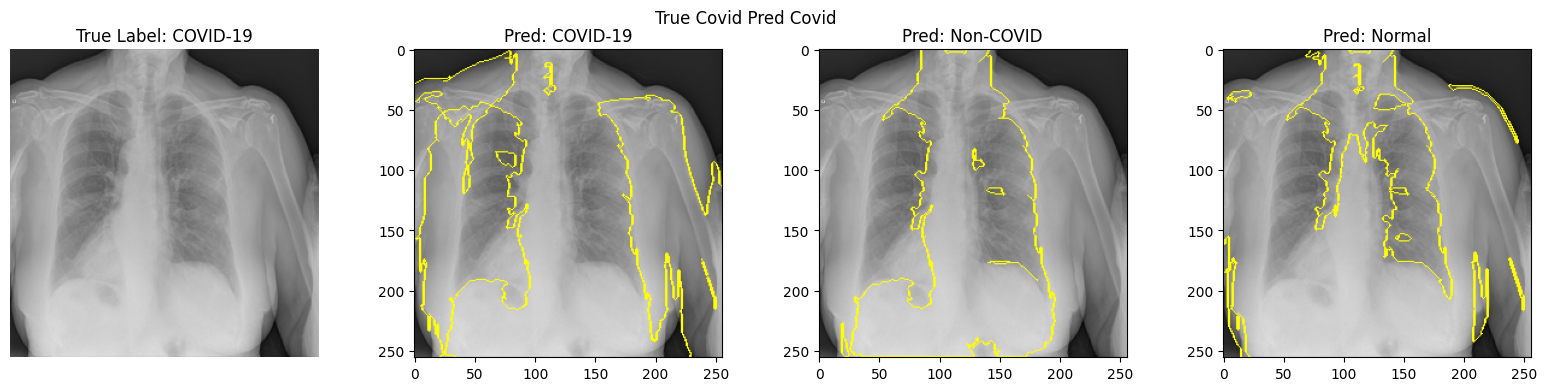

In [ ]:
interpret_model(
    'True Covid Pred Covid',
    covid_true_covid_images[0],
    label_cat['COVID-19'],
    modelv2,
    explainer,
    list(label_cat.keys())
)

Here the model focus on the area nears the left lungs and partially near the right lungs which is not that significant feature. So it can be said that model focus on wrong parts to predict the patient's condition which is not proper.

Although, for non Covid and Normal it is considering the left lung which is correct but it is just considering it and states its prediction which is not right.

  0%|          | 0/2000 [00:00<?, ?it/s]

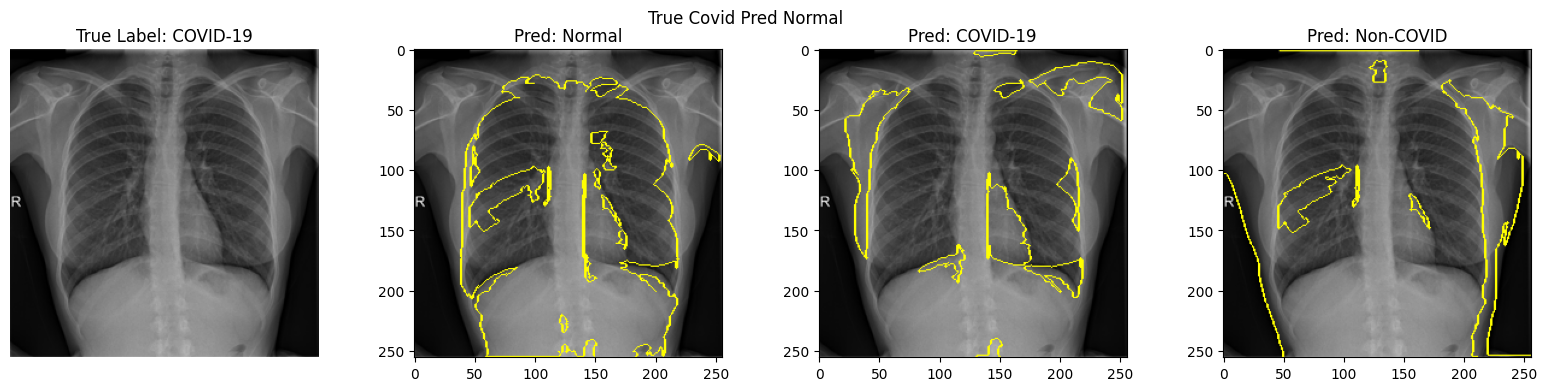

In [ ]:
interpret_model(
    'True Covid Pred Normal',
    covid_false_normal_images[0],
    label_cat['COVID-19'],
    modelv2,
    explainer,
    list(label_cat.keys())
)

When a COVID-19 patient's x-ray is provided the model predicts it as Normal which is totally wrong and this is the case that we should decrease as much as possible because it is critical.

But if seen then the model focuses on the right area. Although, the model even considers the abdomen area as well which is not significant for stating if a person has COVID-19, some other disease or is normal.

  0%|          | 0/2000 [00:00<?, ?it/s]

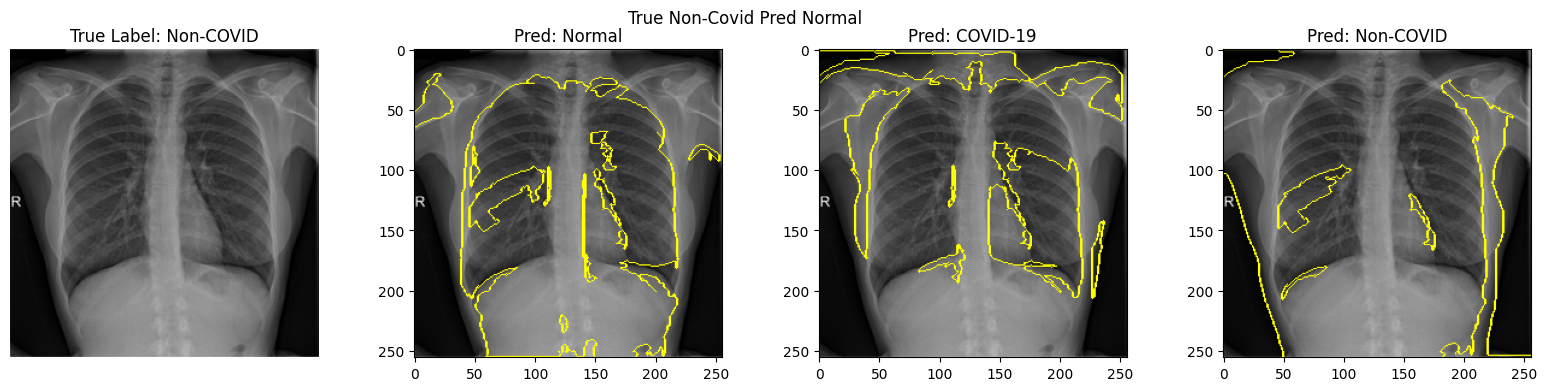

In [ ]:
interpret_model(
    'True Non-Covid Pred Normal',
    covid_false_normal_images[0],
    label_cat['Non-COVID'],
    modelv2,
    explainer,
    list(label_cat.keys())
)

From this interpretation it can be clear that the model does focus on correct area when it is mis-predicting and when it is predicting correctly then it does not consider significant part.

Hence we want our model to cover more features and understand their significance. But in addition to that we even want to compensate with underfitting/overfitting bridge.

# Finetune V2
Instead of having maxpooling which simply takes maximum of window we can have a convolution with stride 2 that will benefit us with dimensionality reduction along with feature learning.

Thus, this would benefit in understanding the features and can prove as a pivotal point on the underfitting-overfitting bridge.

In [ ]:
def create_finetune_model(input_shape, regs, n_classes, drop_rate = 0.1):
    model = tf.keras.models.Sequential()

    model.add(Conv2D(32, kernel_size=(3,3), input_shape=(*input_shape, 1), strides=2, kernel_regularizer=regs, padding='same', activation='relu'))
    model.add(Dropout(drop_rate))

    model.add(Conv2D(64, kernel_size=(3,3), padding='same', activation='relu', strides=2, kernel_regularizer=regs))
    # model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(drop_rate))

    model.add(Conv2D(128, kernel_size=(3,3), padding='same', activation='relu', strides=2,  kernel_regularizer=regs))
    # model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(drop_rate))

    model.add(Conv2D(256, kernel_size=(3,3), padding='same', activation='relu', strides=2,  kernel_regularizer=regs))
    # model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(drop_rate))

    model.add(Flatten())
    model.add(Dense(512, activation='relu',  kernel_regularizer=regs))
    model.add(Dropout(drop_rate))

    model.add(Dense(n_classes, activation='softmax',  kernel_regularizer=regs))

    return model

In [ ]:
# By Emppirical Rule-of-Thumb we will set the Penalty coef to be 0.01
regularizer = tf.keras.regularizers.L1(0.0001)

modelv2 = create_finetune_model(TARGET_SIZE, regularizer, len(CLASSES))

modelv2.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics = [
        'accuracy'
    ]
)

modelv2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 128, 128, 32)      320       
                                                                 
 dropout_25 (Dropout)        (None, 128, 128, 32)      0         
                                                                 
 conv2d_21 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 dropout_26 (Dropout)        (None, 64, 64, 64)        0         
                                                                 
 conv2d_22 (Conv2D)          (None, 32, 32, 128)       73856     
                                                                 
 dropout_27 (Dropout)        (None, 32, 32, 128)       0         
                                                                 
 conv2d_23 (Conv2D)          (None, 16, 16, 256)      

In [ ]:
EPOCHS = 50

finetunev1_model_cb = tf.keras.callbacks.ModelCheckpoint(
    'finetune_model_v2.keras',
    monitor='val_accuracy'
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_accuracy',
    patience = 5
)

hist2 = modelv2.fit(
    train_datagen,
    validation_data = val_datagen,
    callbacks = [finetunev1_model_cb, early_stopping],
    epochs = EPOCHS
)

Epoch 1/50
153/153 [==============================] - 56s 330ms/step - loss: 2.9386 - accuracy: 0.4024 - val_loss: 1.5312 - val_accuracy: 0.5675
Epoch 2/50
153/153 [==============================] - 42s 277ms/step - loss: 1.5595 - accuracy: 0.5342 - val_loss: 1.3823 - val_accuracy: 0.6377
Epoch 3/50
153/153 [==============================] - 44s 290ms/step - loss: 1.4653 - accuracy: 0.5507 - val_loss: 1.3631 - val_accuracy: 0.6063
Epoch 4/50
153/153 [==============================] - 43s 283ms/step - loss: 1.4328 - accuracy: 0.5660 - val_loss: 1.2573 - val_accuracy: 0.6599
Epoch 5/50
153/153 [==============================] - 51s 332ms/step - loss: 1.4055 - accuracy: 0.5818 - val_loss: 1.2947 - val_accuracy: 0.6470
Epoch 6/50
153/153 [==============================] - 44s 287ms/step - loss: 1.3868 - accuracy: 0.5859 - val_loss: 1.2529 - val_accuracy: 0.6747
Epoch 7/50
153/153 [==============================] - 42s 275ms/step - loss: 1.3799 - accuracy: 0.5956 - val_loss: 1.2524 - val_ac

In [ ]:
ftv2_model_path = '/content/finetune_model_v2.keras'
modelv2 = tf.keras.models.load_model(ftv2_model_path)
true_labels_probs, true_label_cat, pred_labels_probs, pred_label_cat = get_preds(modelv2, val_datagen)

  0%|          | 0/33 [00:00<?, ?it/s]

In [ ]:
conf_mat2 = confusion_matrix(true_label_cat, pred_label_cat)
clf_report2 = classification_report(true_label_cat, pred_label_cat, target_names=label_cat.keys())

print(clf_report2)

              precision    recall  f1-score   support

    COVID-19       0.75      0.68      0.71       191
   Non-COVID       0.92      0.91      0.91       183
      Normal       0.67      0.75      0.71       167

    accuracy                           0.78       541
   macro avg       0.78      0.78      0.78       541
weighted avg       0.78      0.78      0.78       541



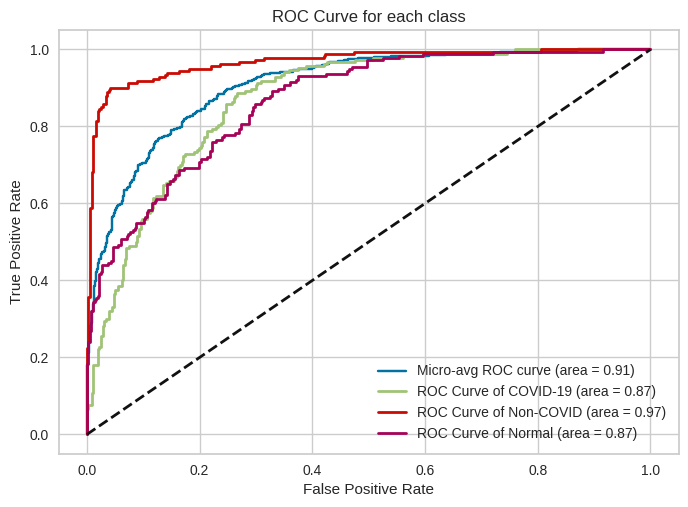

In [ ]:
plot_roc_curve(cat_label, true_labels_probs, pred_labels_probs)

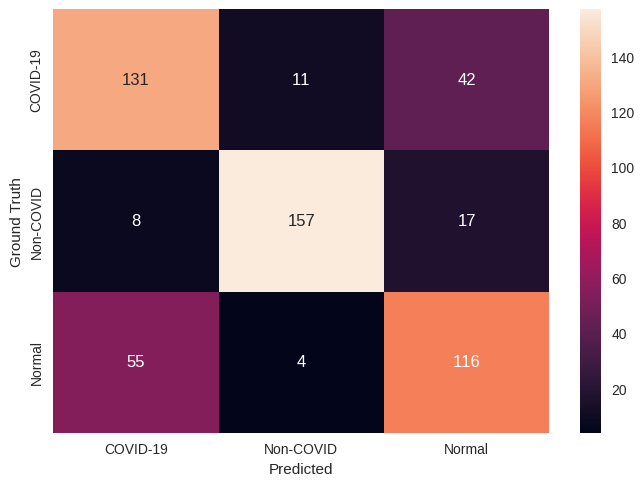

In [ ]:
plot_confusion_matrix(conf_mat2, labels=label_cat.keys())

1/1 [==============================] - 0s 20ms/step


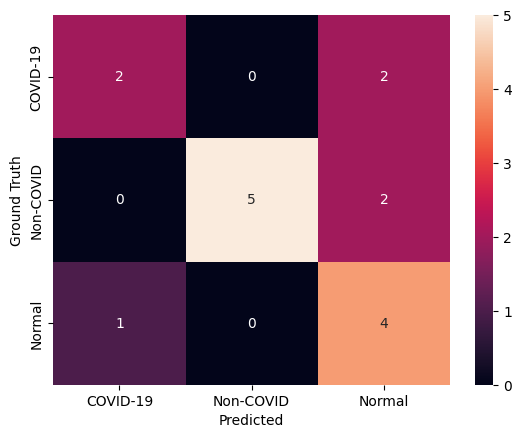

In [ ]:
for inp_images, true_probs in val_datagen:
    pred_probs = modelv2.predict(inp_images)
    break

true_labels = np.argmax(true_probs, axis=-1)
pred_labels = np.argmax(pred_probs, axis=-1)

conf_mat_ = confusion_matrix(true_labels, pred_labels)
plot_confusion_matrix(conf_mat_, label_cat.keys())

In [ ]:
# True covid cases
covid_true_covid = true_labels == label_cat['COVID-19']
covid_true_covid *= pred_labels == label_cat['COVID-19']
covid_true_covid_images = inp_images[covid_true_covid]
covid_true_covid_labels = true_labels[covid_true_covid]

# Find cases where originally the x-ray was of COVID patient and model predicted it to be normal
covid_false_normal = true_labels == label_cat['COVID-19']
covid_false_normal *= pred_labels == label_cat['Normal']
covid_false_normal_images = inp_images[covid_false_normal]
covid_false_normal_labels = true_labels[covid_false_normal]

# Find cases where originally the x-ray was of Non-COVID and model predicetd it to be normal
non_covid_false_normal = true_labels == label_cat['Non-COVID']
non_covid_false_normal *= pred_labels == label_cat['Normal']
non_covid_false_normal_images = inp_images[non_covid_false_normal]
non_covid_false_normal_labels = true_labels[non_covid_false_normal]

In [ ]:
# create an image explainer
explainer = lime_image.LimeImageExplainer()

  0%|          | 0/2000 [00:00<?, ?it/s]

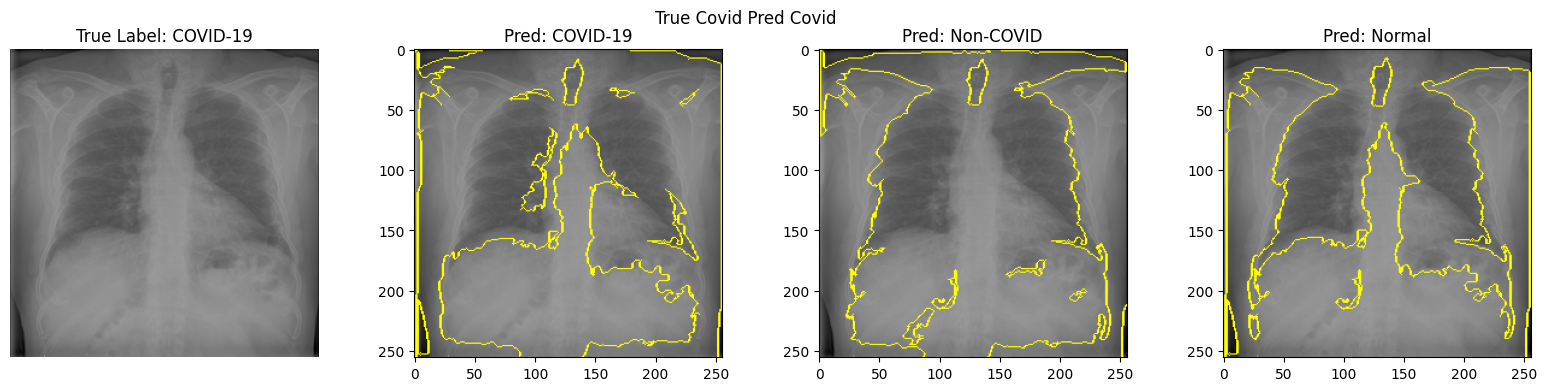

In [ ]:
interpret_model(
    'True Covid Pred Covid',
    covid_true_covid_images[0],
    label_cat['COVID-19'],
    modelv2,
    explainer,
    list(label_cat.keys())
)

As expected from our appraoch the model has started to consider those part of the image that is significant for making prediction.

Although, the model is in correct direction but is not specific. If you see, the model is consider more parts of shoulders as well and missing certain area of lungs mostly the lower parts while making prediction.

  0%|          | 0/2000 [00:00<?, ?it/s]

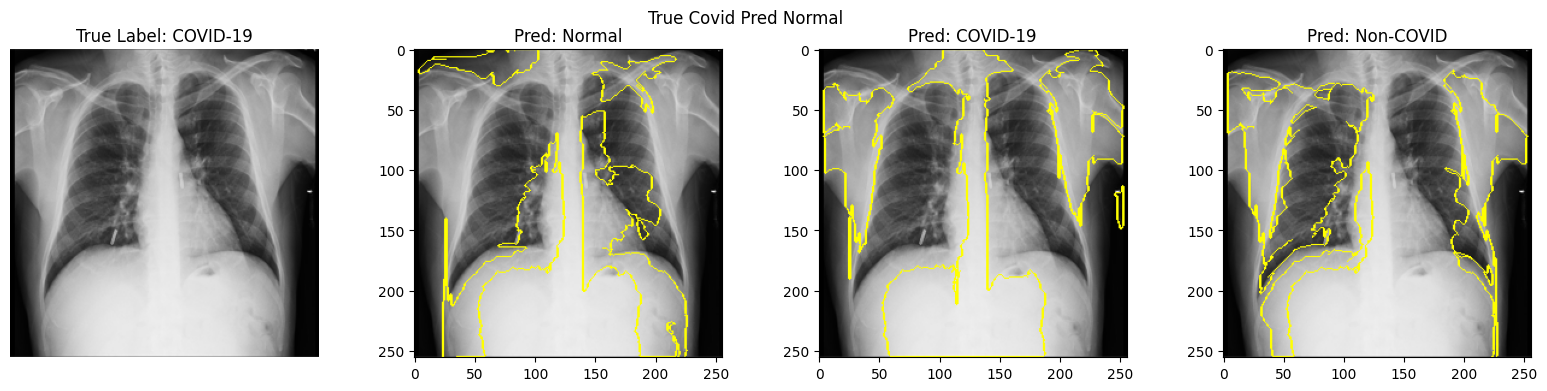

In [ ]:
interpret_model(
    'True Covid Pred Normal',
    covid_false_normal_images[0],
    label_cat['COVID-19'],
    modelv2,
    explainer,
    list(label_cat.keys())
)

  0%|          | 0/2000 [00:00<?, ?it/s]

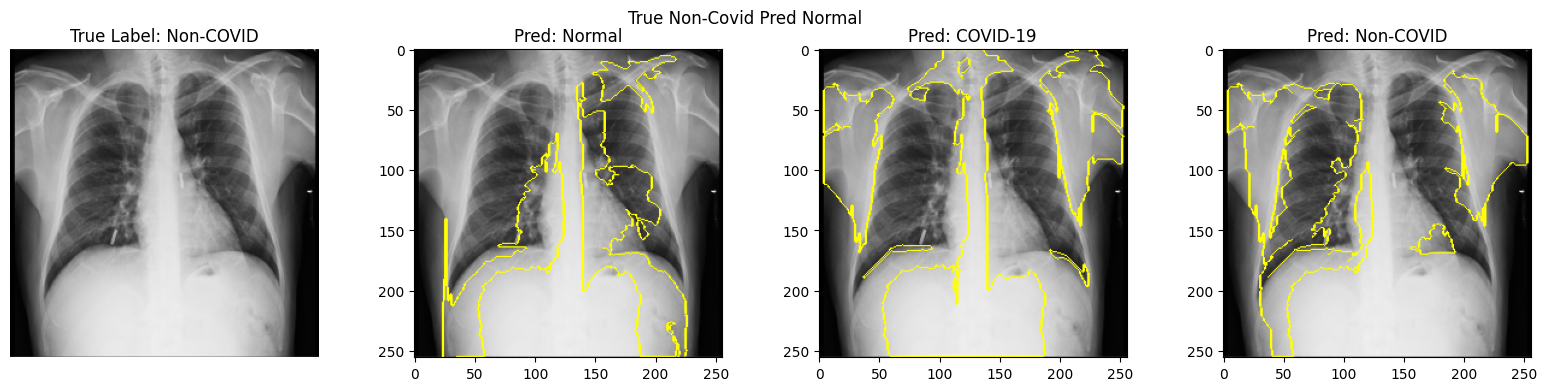

In [ ]:
interpret_model(
    'True Non-Covid Pred Normal',
    covid_false_normal_images[0],
    label_cat['Non-COVID'],
    modelv2,
    explainer,
    list(label_cat.keys())
)

It can be seen that model is failing to provide focus on the major parts as needed. It is considering the middle ribcage part and mostly all things leaving the lungs.

## Future work
Adding strided convolution indeed allowed the model to focus on necessary part of the image while making prediction but at the same time in False Negatives it can be seen that the model is not attending the essential area of the image. Thus as a form of future work we can apply 2 things

1. Use a pretrained model to extract the feature from the image and for that we can unfreeze certain upper layers that are general and then use that feature as input to classifiy.

2. Preprocess the input image to appropriately mask all the things and just provide the lungs image, by doing so we will only provide model what it needs to see to predict for a given xray if patient has COVID or any other disease or is normal.